### Load Alzheimer's RF results

In [1]:
import gdown
import pickle

# https://drive.google.com/file/d/1-4IlB7kf8JxacckS7FoL190G9q-UpLM0/view?usp=drive_link
file_id = "1-4IlB7kf8JxacckS7FoL190G9q-UpLM0"

# Construct the direct-download URL
url = f"https://drive.google.com/uc?id={file_id}"

output = "rf_results.pkl"
gdown.download(url, output, quiet=False)

# Load the pickle
with open(output, "rb") as f:
    results_alz = pickle.load(f)



Downloading...
From: https://drive.google.com/uc?id=1-4IlB7kf8JxacckS7FoL190G9q-UpLM0
To: /content/rf_results.pkl
100%|██████████| 14.8k/14.8k [00:00<00:00, 1.59MB/s]


### Load Parkinson's RF results

In [2]:
#    https://drive.google.com/file/d/1-26wbeKxkRet_TuEqPWq7LTL8Yl2MNqn/view?usp=drive_link
file_id = "1-26wbeKxkRet_TuEqPWq7LTL8Yl2MNqn"

# Construct the direct-download URL
url = f"https://drive.google.com/uc?id={file_id}"

output = "rf_results.pkl"
gdown.download(url, output, quiet=False)

# Load the pickle
with open(output, "rb") as f:
    results_park = pickle.load(f)



Downloading...
From: https://drive.google.com/uc?id=1-26wbeKxkRet_TuEqPWq7LTL8Yl2MNqn
To: /content/rf_results.pkl
100%|██████████| 7.25k/7.25k [00:00<00:00, 13.6MB/s]


In [3]:
import pandas as pd

# results_alz and results_park have the structure:
# { cell_type: { 'female': df_feat, 'male': df_feat }, ... }

records = []
cell_types = set(results_alz.keys()) & set(results_park.keys())
sexes      = ['female','male']

for ct in sorted(cell_types):
    for sex in sexes:
        df_a = results_alz[ct].get(sex)
        df_p = results_park[ct].get(sex)
        if df_a is None or df_p is None:
            # one of them missing or filtered out
            continue

        set_a = set(df_a.index)
        set_p = set(df_p.index)
        inter = set_a & set_p
        union = set_a | set_p

        records.append({
            'cell_type': ct,
            'sex':       sex,
            'n_alz':     len(set_a),
            'n_park':    len(set_p),
            'overlap':   len(inter),
            'jaccard':   len(inter) / len(union) if union else 0,
            'alz_only':  sorted(set_a - set_p),
            'park_only': sorted(set_p - set_a),
            'common':    sorted(inter)
        })

df_compare = pd.DataFrame(records)

print(df_compare[['cell_type','sex','n_alz','n_park','overlap','jaccard']])



                        cell_type     sex  n_alz  n_park  overlap   jaccard
0                endothelial cell  female    100      48        9  0.064748
1                endothelial cell    male    100      79       10  0.059172
2                          neuron  female     17      32        6  0.139535
3                          neuron    male     14      21        0  0.000000
4                 oligodendrocyte  female     26      34        4  0.071429
5                 oligodendrocyte    male     22      11        1  0.031250
6  oligodendrocyte precursor cell  female     46      90        7  0.054264
7  oligodendrocyte precursor cell    male     37      29        2  0.031250


In [4]:
# assume df_compare has the columns:
# ['cell_type','sex','overlap','common',...]
for _, row in df_compare.iterrows():
    ct     = row['cell_type']
    sex    = row['sex']
    shared = row['common']      # list of shared genes
    # if none, skip
    if not shared:
        continue

    print(f"{ct} / {sex} — shared {len(shared)} genes:")
    print(", ".join(shared))
    print()


endothelial cell / female — shared 9 genes:
HSP90AA1, HSPB1, MT-CO1, MT-CO2, MT-CO3, MT-ND1, MT-ND4, NEAT1, PECAM1

endothelial cell / male — shared 10 genes:
ATP10A, FTL, GAPDH, ID1, MT-CO1, MT-CO2, SLC2A1, SLCO4A1, THSD4, TNS1

neuron / female — shared 6 genes:
LINC00486, MT-CO1, MT-CO2, MT-CO3, MT-RNR2, XIST

oligodendrocyte / female — shared 4 genes:
HSP90AA1, MT-CO1, NEAT1, XIST

oligodendrocyte / male — shared 1 genes:
HSP90AA1

oligodendrocyte precursor cell / female — shared 7 genes:
DGKG, GRIK1, LINC00486, MT-CO1, PARD3, SMOC1, XIST

oligodendrocyte precursor cell / male — shared 2 genes:
HSP90AA1, VCAN



In [5]:
# Build a summary list with Jaccard
records = []
for _, row in df_compare.iterrows():
    shared = row['common']
    if not shared:
        continue

    records.append({
        'Cell type':      row['cell_type'],
        'Sex':            row['sex'].capitalize(),
        'Jaccard Index':  f"{row['jaccard']:.2f}",
        'Shared genes':   ", ".join(shared)
    })


summary_df = pd.DataFrame(records)

# Sort
summary_df = summary_df.sort_values(['Cell type','Sex']).reset_index(drop=True)

# HTML table
from IPython.display import display, HTML
display(HTML(summary_df.to_html(index=False, escape=False)))


Cell type,Sex,Jaccard Index,Shared genes
endothelial cell,Female,0.06,"HSP90AA1, HSPB1, MT-CO1, MT-CO2, MT-CO3, MT-ND1, MT-ND4, NEAT1, PECAM1"
endothelial cell,Male,0.06,"ATP10A, FTL, GAPDH, ID1, MT-CO1, MT-CO2, SLC2A1, SLCO4A1, THSD4, TNS1"
neuron,Female,0.14,"LINC00486, MT-CO1, MT-CO2, MT-CO3, MT-RNR2, XIST"
oligodendrocyte,Female,0.07,"HSP90AA1, MT-CO1, NEAT1, XIST"
oligodendrocyte,Male,0.03,HSP90AA1
oligodendrocyte precursor cell,Female,0.05,"DGKG, GRIK1, LINC00486, MT-CO1, PARD3, SMOC1, XIST"
oligodendrocyte precursor cell,Male,0.03,"HSP90AA1, VCAN"


In [6]:
# Make a nice looking table
from IPython.display import display, HTML

# CSS styles
styles = [
    {
        'selector': 'th',
        'props': [
            ('background-color', '#4F81BD'),
            ('color', 'white'),
            ('font-weight', 'bold'),
            ('font-size', '14px'),
            ('padding', '8px')
        ]
    },
    {
        'selector': 'td',
        'props': [
            ('padding', '8px'),
            ('font-size', '12px'),
            ('text-align', 'left')
        ]
    },
    {
        'selector': 'tbody tr:nth-child(odd)',
        'props': [('background-color', '#F2F2F2')]
    },
    {
        'selector': 'tbody tr:nth-child(even)',
        'props': [('background-color', 'white')]
    }
]

# Build the Styler
styled = (
    summary_df.style
      .set_table_styles(styles)
      .set_caption("**Shared top-100 RF predictors**<br>Alzheimer vs. Parkinson")
)

display(styled)



,Cell type,Sex,Jaccard Index,Shared genes
0,endothelial cell,Female,0.06,"HSP90AA1, HSPB1, MT-CO1, MT-CO2, MT-CO3, MT-ND1, MT-ND4, NEAT1, PECAM1"
1,endothelial cell,Male,0.06,"ATP10A, FTL, GAPDH, ID1, MT-CO1, MT-CO2, SLC2A1, SLCO4A1, THSD4, TNS1"
2,neuron,Female,0.14,"LINC00486, MT-CO1, MT-CO2, MT-CO3, MT-RNR2, XIST"
3,oligodendrocyte,Female,0.07,"HSP90AA1, MT-CO1, NEAT1, XIST"
4,oligodendrocyte,Male,0.03,HSP90AA1
5,oligodendrocyte precursor cell,Female,0.05,"DGKG, GRIK1, LINC00486, MT-CO1, PARD3, SMOC1, XIST"
6,oligodendrocyte precursor cell,Male,0.03,"HSP90AA1, VCAN"


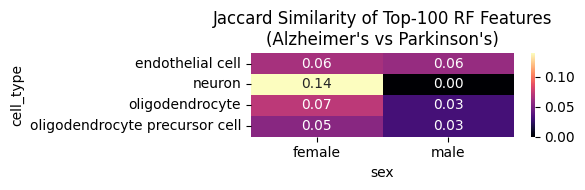

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# pivot to make a matrix cell_type × sex
jmat = df_compare.pivot(index='cell_type', columns='sex', values='jaccard')

plt.figure(figsize=(6, len(jmat)*0.5))
sns.heatmap(jmat, annot=True, cmap='magma', fmt=".2f")
plt.title("Jaccard Similarity of Top-100 RF Features\n(Alzheimer's vs Parkinson's)")
plt.tight_layout()
plt.show()
